<a href="https://colab.research.google.com/github/hygoni/ToyTorch/blob/master/4.CNN/VGG16_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision import transforms, datasets, models
from IPython.display import clear_output
import torch
import torch.optim as optim
import torch.cuda as cuda
import torch.utils.data as datautil
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

## Preparing Data

In [2]:
from google.colab import files
print('upload kaggle.json')
files.upload()
!mkdir /root/.kaggle/
!cp kaggle.json /root/.kaggle/

upload kaggle.json


Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [0]:
!kaggle datasets download -d prasunroy/natural-images
!unzip natural-images.zip
clear_output()

In [4]:
!ls

'kaggle (1).json'   kaggle.json      natural-images.zip
'kaggle (2).json'   natural_images   sample_data


In [5]:
!ls natural_images

airplane  car  cat  dog  flower  fruit	motorbike  person


In [0]:
class_ = []
img_class = []
n_images = []
dim = []
dim_images = []
height = []
width = []

for folder in os.listdir('./natural_images'):
    class_.append(folder)
    files = os.listdir('./natural_images/' + folder)
    n_images.append(len(files))
    for file in files:
        img_class.append(folder)
        image = np.array(Image.open('./natural_images/' + folder + '/' + file))
        height.append(image.shape[0])
        width.append(image.shape[1])
        dim_images.append(image.shape[2])
    dim.append(image.shape[2])

In [7]:
df_folder = pd.DataFrame({'class' : class_, 'images' : n_images, 'dim' : dim})
df_folder

,class,images,dim
0,car,968,3
1,dog,702,3
2,airplane,727,3
3,fruit,1000,3
4,person,986,3
5,cat,885,3
6,motorbike,788,3
7,flower,843,3


In [8]:
df_images = pd.DataFrame({'class' : img_class, 'width' : width, 'height' : height, 'dim' : dim_images})
df_images.head()

,class,width,height,dim
0,car,100,100,3
1,car,100,100,3
2,car,100,100,3
3,car,100,100,3
4,car,100,100,3


In [9]:
df_images.groupby('class').describe()

width                                 ...  dim               
            count        mean         std    min  ...  25%  50%  75%  max
class                                             ...                    
airplane    727.0  296.623109   13.250642  224.0  ...  3.0  3.0  3.0  3.0
car         968.0  100.000000    0.000000  100.0  ...  3.0  3.0  3.0  3.0
cat         885.0  315.694915  104.820174   59.0  ...  3.0  3.0  3.0  3.0
dog         702.0  283.857550  104.505232   43.0  ...  3.0  3.0  3.0  3.0
flower      843.0  386.609727  224.930960   51.0  ...  3.0  3.0  3.0  3.0
fruit      1000.0  100.000000    0.000000  100.0  ...  3.0  3.0  3.0  3.0
motorbike   788.0  191.559645    9.987171  124.0  ...  3.0  3.0  3.0  3.0
person      986.0  255.981744    0.330622  250.0  ...  3.0  3.0  3.0  3.0

[8 rows x 24 columns]

## Data Augumentation

In [0]:
image_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),    
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        
    ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
}

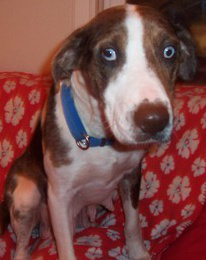

In [11]:
import random
n = str(random.randint(1, 700)).zfill(4)
img = Image.open('./natural_images/dog/dog_{}.jpg'.format(n))
img

In [0]:
def imshow(img, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img*std + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')
    
    return ax, img   

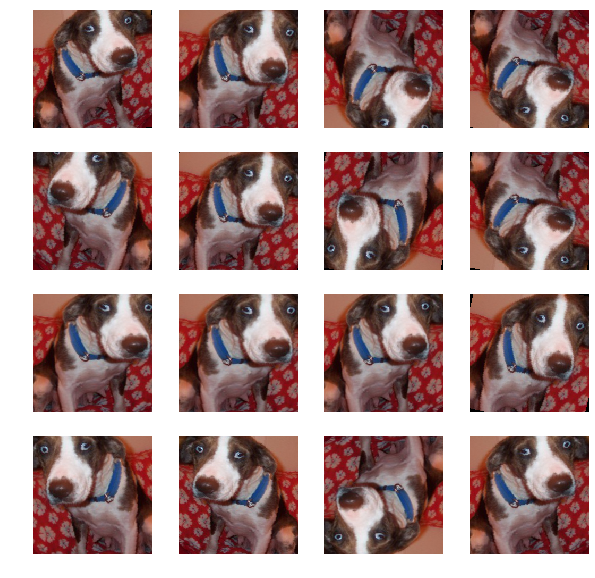

In [13]:
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    transform = image_transforms['train']
    imshow(transform(img), ax=ax)

In [0]:
batch_size = 64
all_set = datasets.ImageFolder('./natural_images/')

all_len = len(all_set)
train_len = int(all_len * 0.8)
val_len = int(all_len * 0.1)
test_len = all_len - train_len - val_len

train_set, val_set, test_set = datautil.random_split(all_set, [train_len, val_len, test_len])
train_set.dataset.transform = image_transforms['train']
val_set.dataset.transform = image_transforms['val']
test_set.dataset.transform = image_transforms['test']

train_loader = datautil.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = datautil.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = datautil.DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [15]:
train_iter = iter(train_loader)
img, label = next(train_iter)
print(img.shape, label.shape)

torch.Size([64, 3, 244, 244]) torch.Size([64])


In [27]:
vgg16 = models.vgg16(pretrained=True)
if cuda:
    vgg16 = vgg16.to(device)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
for param in vgg16.parameters():
    param.requires_grad = False

In [0]:
in_size = vgg16.classifier[6].in_features
n_class = 8
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(in_size, 256),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, n_class),
    nn.LogSoftmax()
)

In [19]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
get_loss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(vgg16.parameters(), lr = learning_rate)

In [21]:
cuda

True

In [0]:
n_epoch = 20
train_loss = []

for epoch in range(n_epoch):
    print('Epoch : {}'.format(epoch))
    vgg16.train()
    for i, (img, label) in enumerate(train_loader):
        if i % 20 == 19:
            print('[{}] : {}'.format(i+1, train_loss[-1]))
        if cuda:
            img = img.to(device)
            label = label.to(device)
        optimizer.zero_grad()

        out = vgg16(img)
        loss = get_loss(out, label)
        loss.backward()
        train_loss.append(loss.data)
        optimizer.step()

Epoch : 0
[20] : 14.642966270446777


In [0]:
plt.plot(train_loss)